In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

# Pascal VOC dataset

In [3]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/models'),
 PosixPath('data/pascal/VOCtrainval_11-May-2012.tar'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/largest.csv'),
 PosixPath('data/pascal/pascal'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/VOC2007'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/VOC2012'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/count.csv'),
 PosixPath('data/pascal/.ipynb_checkpoints'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_val2007.json')]

In [4]:
train_json = json.load((PATH / 'pascal_train2007.json').open())

### Explore dataset

In [5]:
train_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
len(train_json['images'])

2501

In [7]:
train_json['images'][:3]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334}]

In [8]:
len(train_json['annotations'])

7844

In [126]:
train_json['annotations'][:3]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]},
 {'area': 81326,
  'bbox': [89, 77, 314, 259],
  'category_id': 13,
  'id': 3,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]]}]

In [10]:
train_json['categories']

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'},
 {'id': 5, 'name': 'bottle', 'supercategory': 'none'},
 {'id': 6, 'name': 'bus', 'supercategory': 'none'},
 {'id': 7, 'name': 'car', 'supercategory': 'none'},
 {'id': 8, 'name': 'cat', 'supercategory': 'none'},
 {'id': 9, 'name': 'chair', 'supercategory': 'none'},
 {'id': 10, 'name': 'cow', 'supercategory': 'none'},
 {'id': 11, 'name': 'diningtable', 'supercategory': 'none'},
 {'id': 12, 'name': 'dog', 'supercategory': 'none'},
 {'id': 13, 'name': 'horse', 'supercategory': 'none'},
 {'id': 14, 'name': 'motorbike', 'supercategory': 'none'},
 {'id': 15, 'name': 'person', 'supercategory': 'none'},
 {'id': 16, 'name': 'pottedplant', 'supercategory': 'none'},
 {'id': 17, 'name': 'sheep', 'supercategory': 'none'},
 {'id': 18, 'name': 'sofa', 'supercategory': 'none'},
 {'id': 

In [11]:
list((PATH/'VOC2007').iterdir())

[PosixPath('data/pascal/VOC2007/JPEGImages.tar'),
 PosixPath('data/pascal/VOC2007/JPEGImages'),
 PosixPath('data/pascal/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOC2007/Annotations'),
 PosixPath('data/pascal/VOC2007/ImageSets')]

In [12]:
list((PATH/'VOC2007'/'JPEGImages').iterdir())[:10]

[PosixPath('data/pascal/VOC2007/JPEGImages/000052.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/003344.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/001941.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/008160.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/008203.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/002933.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/000099.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/007736.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/001293.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/001409.jpg')]

### Create data structures

In [13]:
categories = {category['id']:category['name'] for category in train_json['categories']}

In [14]:
categories[1], categories[7]

('aeroplane', 'car')

In [15]:
image_props = {}

for image in train_json['images']:
    image_props[image['id']] = {
        'filename' : image['file_name'],
        'objects' :[]
    }

for annotation in train_json['annotations']:
    if not annotation['ignore']:
        image_props[annotation['image_id']]['objects'].append((annotation['category_id'], annotation['bbox']))

In [16]:
image_props[17]

{'filename': '000017.jpg',
 'objects': [(15, [184, 61, 95, 138]), (13, [89, 77, 314, 259])]}

In [17]:
categories[13]

'horse'

### Display image

In [18]:
%matplotlib inline

In [19]:
def sort_by_size(obj):
    return sorted(obj, key=lambda x : x[1][2] * x[1][3], reverse=True)

In [20]:
def draw_outline(obj, width):
    obj.set_path_effects([patheffects.Stroke(linewidth=width, foreground='black'), patheffects.Normal()])

def draw_bbox(ax, obj):    
    category, bbox = obj
    patch = ax.add_patch(patches.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2], height=bbox[3], 
                                           fill=False, edgecolor='yellow', lw=2))
    draw_outline(patch, 4)
    text = ax.text(bbox[0], bbox[1], s=categories[category], color='black', fontsize=12,
                   verticalalignment='bottom',
                   bbox=dict(facecolor='yellow', pad=2))
    
def draw_image(id, largest=False):
    fig, ax = plt.subplots(figsize=(16,8))
    img = open_image(PATH/'VOC2007'/'JPEGImages'/image_props[id]['filename'])
    
    # sort bboxes by size, used later
    sorted_bboxes = sort_by_size(image_props[id]['objects'])
    
    for obj in sorted_bboxes:
        draw_bbox(ax, obj)
        if largest:
            break
            
    ax.imshow(img);

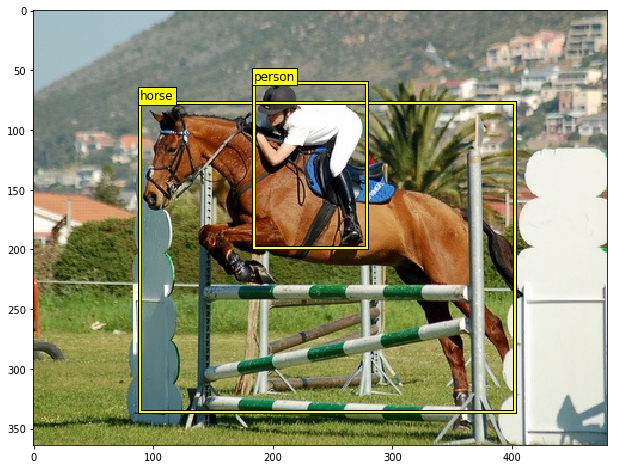

In [21]:
draw_image(17)

# Largest item classifier

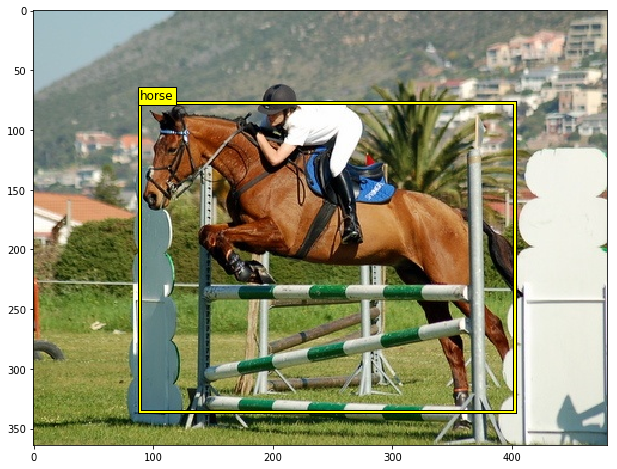

In [22]:
draw_image(17, largest=True)

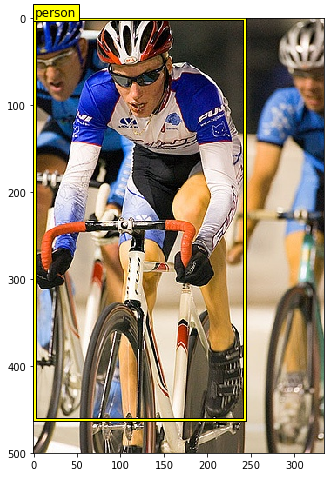

In [23]:
draw_image(23, largest=True)

In [24]:
largest_objects = {img_prop['filename']:categories[sort_by_size(img_prop['objects'])[0][0]] 
                   for k, img_prop in image_props.items()}

In [25]:
largest_df = pd.DataFrame.from_dict(largest_objects, orient='index')
largest_df.head()

0
000012.jpg        car
000017.jpg      horse
000023.jpg     person
000026.jpg        car
000032.jpg  aeroplane

In [26]:
LARGEST_CSV = PATH/'largest.csv'
largest_df.to_csv(LARGEST_CSV)

In [27]:
model = resnet34
sz = 224
bs = 64
JPEGS = 'VOC2007/JPEGImages'

In [28]:
tfms = tfms_from_model(model, sz, transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, LARGEST_CSV, bs, tfms)

In [29]:
x, y = next(iter(md.val_dl)) # first minibatch

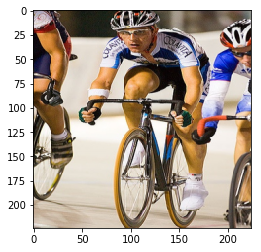

In [30]:
plt.imshow(md.trn_ds.denorm(to_np(x))[0]);

In [31]:
learner = ConvLearner.pretrained(model, md, metrics=[accuracy])

In [32]:
learner.lr_find(1e-5, 100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 28/32 [00:11<00:01,  2.44it/s, loss=59.7]

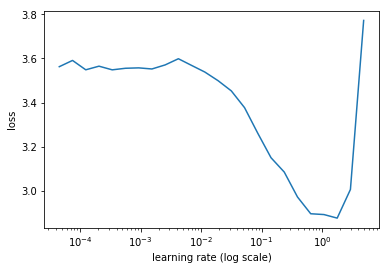

In [33]:
learner.sched.plot(3, 1)

### Train model

In [34]:
lr = 2e-2
learner.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:07<00:02,  3.13it/s, loss=2.15]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      2.008863   1.072617   0.721755  



[1.0726168, 0.7217548042535782]

In [35]:
learner.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.116012   0.79338    0.780649  



[0.7933796, 0.7806490361690521]

In [36]:
learner.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.917121   0.701296   0.784555  



[0.7012956, 0.7845552861690521]

In [37]:
learner.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.84828    0.672324   0.790865  



[0.672324, 0.790865384042263]

In [38]:
learner.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.733434   0.613649   0.8128    



[0.6136489, 0.8128004819154739]

In [39]:
learner.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.733155   0.602986   0.815204  



[0.6029855, 0.8152043297886848]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 97%|█████████▋| 31/32 [00:17<00:00,  1.76it/s, loss=3.05] 

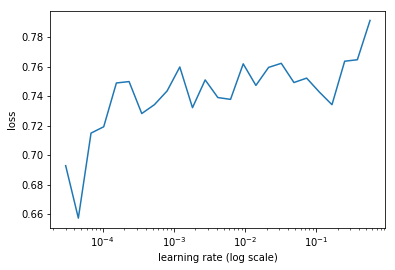

In [41]:
lrs = np.array([lr/1000,lr/100,lr])

learner.freeze_to(-2)

lrf=learner.lr_find(lrs/1000)
learner.sched.plot(1)

In [42]:
learner.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 34%|███▍      | 11/32 [00:06<00:13,  1.60it/s, loss=0.79] 


Exception in thread Thread-17:
Traceback (most recent call last):
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.758818   0.636104   0.804087  



[0.6361041, 0.8040865361690521]

In [43]:
learner.unfreeze()

In [44]:
learner.fit(lrs/5, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.712897   0.61883    0.796725  
    1      0.710047   0.618653   0.798227                  



[0.6186535, 0.7982271611690521]

In [45]:
x, y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learner.model, x), -1)
x, preds = to_np(x), to_np(probs)

In [46]:
preds

array([[0.00018, 0.17392, 0.00101, ..., 0.00025, 0.00041, 0.0002 ],
       [0.00002, 0.00032, 0.00003, ..., 0.78116, 0.00019, 0.00212],
       [0.00615, 0.00525, 0.89841, ..., 0.00014, 0.00068, 0.00104],
       ...,
       [0.00005, 0.00122, 0.00006, ..., 0.05961, 0.00035, 0.00071],
       [0.00007, 0.00249, 0.00102, ..., 0.00094, 0.00027, 0.00015],
       [0.01193, 0.00141, 0.01905, ..., 0.00192, 0.00388, 0.00478]], dtype=float32)

In [47]:
preds = np.argmax(preds, -1)

In [48]:
preds

array([14, 17,  2, 14, 14,  6, 12,  8,  2,  9, 15,  6, 17,  7, 12,  0, 14, 14,  7, 19,  1,  8, 19, 13, 14,
       14, 14,  5,  9, 18, 13,  0,  2,  6, 18, 11, 12,  6,  0, 10,  6, 13, 12, 14,  3, 13, 14,  7, 12, 13,
       12, 14, 13,  2, 14, 11,  6,  0,  2,  0,  2,  7, 14,  9])

In [49]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


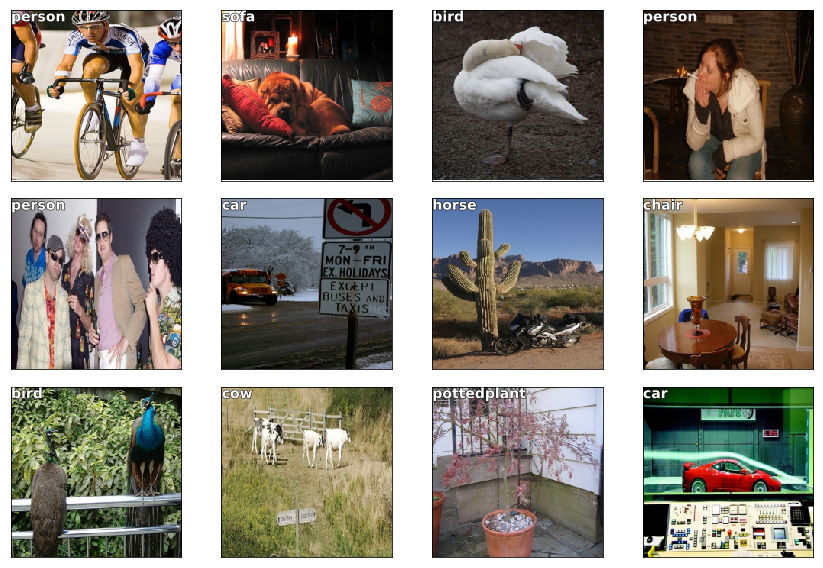

In [50]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    txt = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), txt)
plt.tight_layout()

### Known object counter

In [96]:
obj_count = {img_prop['filename']:len(img_prop['objects']) for k, img_prop in image_props.items()}

In [97]:
df = pd.DataFrame.from_dict(obj_count, orient='index').reset_index()
df.head()

index  0
0  000012.jpg  1
1  000017.jpg  2
2  000023.jpg  5
3  000026.jpg  1
4  000032.jpg  4

In [98]:
COUNT_CSV = PATH/'count.csv'
df.to_csv(COUNT_CSV, index=False)

In [99]:
model = resnet34
sz=224
bs = 64
JPEGS = 'VOC2007/JPEGImages'

In [100]:
tfms = tfms_from_model(model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, COUNT_CSV, tfms=tfms, continuous=True)

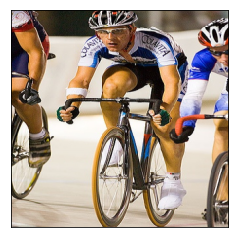

In [101]:
x,y=next(iter(md.val_dl))
show_img(md.val_ds.denorm(to_np(x))[0]);

In [102]:
to_np(y[0])

array([3.], dtype=float32)

In [104]:
head_reg = nn.Sequential(Flatten(), nn.Linear(25088, 1)) # resnet last lyr = 7 * 7 * 512 = 25088, 1 outputs for number of objects
learn = ConvLearner.pretrained(model, md, custom_head=head_reg)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 59%|█████▉    | 19/32 [00:06<00:04,  2.72it/s, loss=15.5]


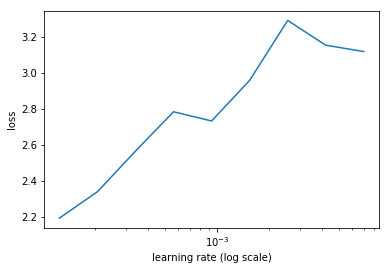

In [105]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

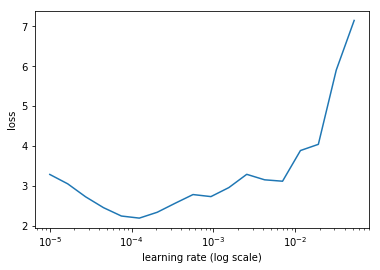

In [108]:
learn.sched.plot(0, 1)

In [109]:
lr = 5e-5

In [110]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      1.768387   1.623452  
    1      1.546253   1.37431                             
    2      1.380416   1.34869                             



[1.3486898]

In [111]:
lrs = np.array([lr/100,lr/10,lr])

In [112]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|███████▌  | 24/32 [00:15<00:05,  1.51it/s, loss=8.31]

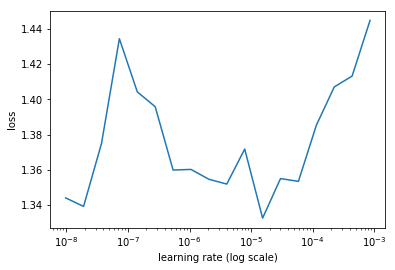

In [113]:
lrf=learn.lr_find(lrs/10000)
learn.sched.plot(1)

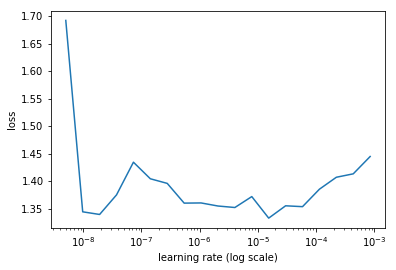

In [114]:
learn.sched.plot(0)

In [115]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 38%|███▊      | 12/32 [00:07<00:12,  1.63it/s, loss=1.34]


Exception in thread Thread-54:
Traceback (most recent call last):
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                            
    0      1.263283   1.269989  
    1      1.168506   1.189885                            
    2      1.047064   1.182119                            



[1.1821189]

In [116]:
learn.freeze_to(-3)

In [117]:
learn.fit(lrs, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      1.036097   1.177124  
    1      0.926263   1.15252                              



[1.1525202]

In [118]:
learn.save('counter')

In [119]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


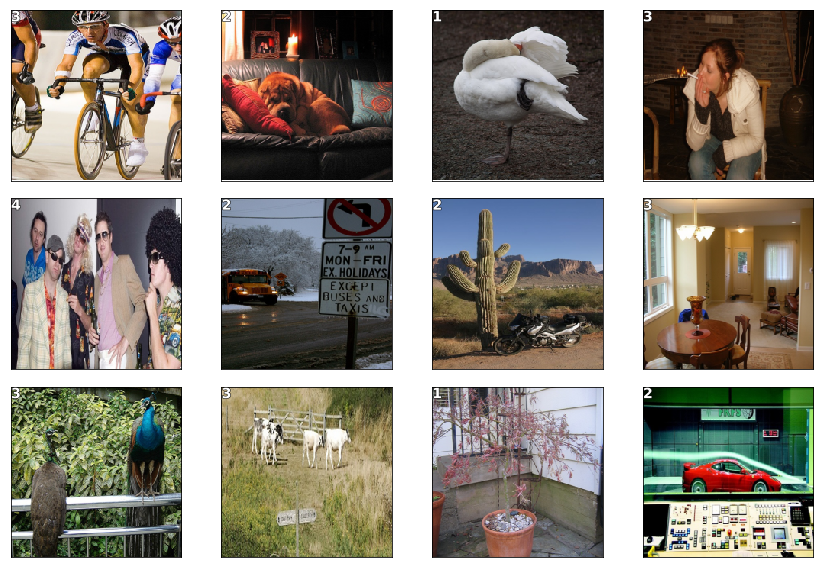

In [125]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    
    txt = str(int(round(preds[i][0])))
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), txt)
plt.tight_layout()

In [198]:
for fn in md.val_ds.fnames[:12]:
    print(fn[len('VOC2007/JPEGImages/'):] + ' - ' + str(obj_count[fn[len('VOC2007/JPEGImages/'):]]))

000129.jpg - 3
000140.jpg - 2
000189.jpg - 1
000192.jpg - 1
000200.jpg - 7
000207.jpg - 1
000219.jpg - 1
000235.jpg - 3
000294.jpg - 2
000306.jpg - 3
000307.jpg - 2
000317.jpg - 1


### Known object counter using classification

In [62]:
obj_count = {img_prop['filename']:str(len(img_prop['objects'])) for k, img_prop in image_props.items()}

In [63]:
df = pd.DataFrame.from_dict(obj_count, orient='index').reset_index()
df.head()

index  0
0  000012.jpg  1
1  000017.jpg  2
2  000023.jpg  5
3  000026.jpg  1
4  000032.jpg  4

In [64]:
sorted(df[0].unique())

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '19',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [66]:
COUNT_CSV = PATH/'count_classes.csv'
df.to_csv(COUNT_CSV, index=False)

In [67]:
model = resnet34
sz=224
bs = 64
JPEGS = 'VOC2007/JPEGImages'

In [68]:
tfms = tfms_from_model(model, sz, transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, COUNT_CSV, bs, tfms)

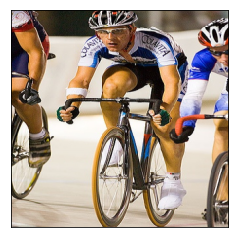

In [69]:
x,y=next(iter(md.val_dl))
show_img(md.val_ds.denorm(to_np(x))[0]);

In [72]:
learn = ConvLearner.pretrained(model, md, metrics=[accuracy])


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████▏ | 26/32 [00:09<00:02,  2.68it/s, loss=17.4]


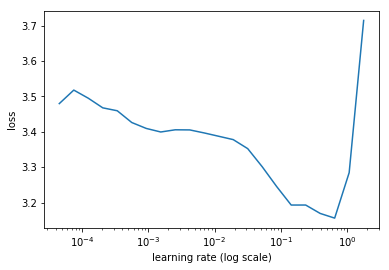

In [73]:
learn.lr_find(1e-5,100)
learn.sched.plot(3, 1)

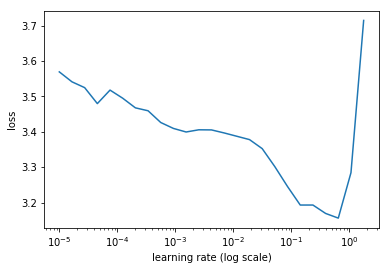

In [74]:
learn.sched.plot(0,1)

In [75]:
lr = 5e-2

In [76]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      2.320835   1.685779   0.492037  
    1      2.004442   1.553909   0.479868                 
    2      1.709514   1.552611   0.497446                 



[1.5526114, 0.4974459111690521]

In [77]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.407497   1.521222   0.46259   
    1      1.466039   1.574616   0.477013                 
    2      1.394405   1.489191   0.499399                 
    3      1.285008   1.461373   0.497446                 



[1.4613734, 0.4974459111690521]

In [78]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.235022   1.484457   0.497296  
    1      1.285066   1.572355   0.485727                 
    2      1.213151   1.494041   0.514423                 
    3      1.210866   1.587608   0.468149                 
    4      1.181819   1.547859   0.475511                 
    5      1.079318   1.499169   0.475962                 
    6      1.001064   1.500441   0.472506                 



[1.5004413, 0.47250600904226303]

In [79]:
lrs = np.array([lr/100,lr/10,lr])

In [80]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 97%|█████████▋| 31/32 [00:19<00:00,  1.57it/s, loss=6.19] 

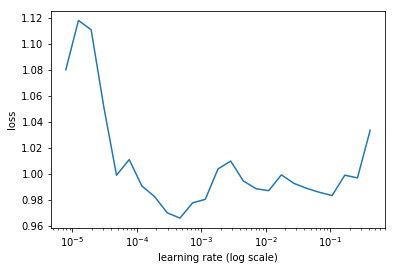

In [81]:
lrf=learn.lr_find(lrs/10000)
learn.sched.plot(1)

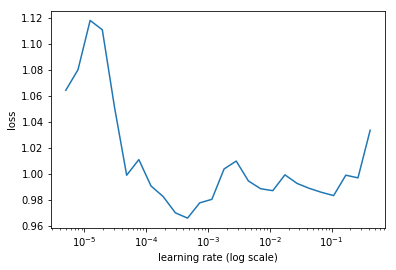

In [82]:
learn.sched.plot(0)

In [83]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 12%|█▎        | 4/32 [00:03<00:22,  1.24it/s, loss=0.919]

Exception in thread Thread-41:
Traceback (most recent call last):
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      1.110483   1.466881   0.492488  
    1      1.054483   1.529702   0.479417                 
    2      0.838953   1.544272   0.464694                  



[1.5442721, 0.46469350904226303]

In [84]:
learn.freeze_to(-3)

In [85]:
learn.fit(lrs, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.660482   1.653096   0.484826  
    1      0.53585    1.661077   0.490084                  



[1.6610775, 0.49008413404226303]

In [174]:
learn.save('counter')

In [86]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [90]:
x, y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x, preds = to_np(x), to_np(probs)

In [91]:
preds


array([[0.00013, 0.08018, 0.01024, ..., 0.02726, 0.00834, 0.11196],
       [0.21408, 0.     , 0.00001, ..., 0.00001, 0.     , 0.     ],
       [0.99938, 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       ...,
       [0.0333 , 0.00002, 0.00003, ..., 0.00001, 0.00001, 0.00004],
       [0.13977, 0.00057, 0.00023, ..., 0.00352, 0.00155, 0.00296],
       [0.95224, 0.     , 0.     , ..., 0.     , 0.00001, 0.     ]], dtype=float32)

In [92]:
preds = np.argmax(preds, -1)


In [93]:
preds

array([12, 10,  0, 10, 13,  0, 10, 12,  0, 11, 11,  0, 10,  0, 10,  0,  1,  1, 10, 10, 12, 16, 10,  0, 10,
       10,  3, 10, 10,  0, 13,  0,  0, 15,  0, 11, 12, 11, 14, 11, 12, 10, 10, 10,  0, 10, 11,  0, 10,  0,
       12, 12,  0,  0, 10, 11, 13,  0,  0,  0,  0, 10, 12,  0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


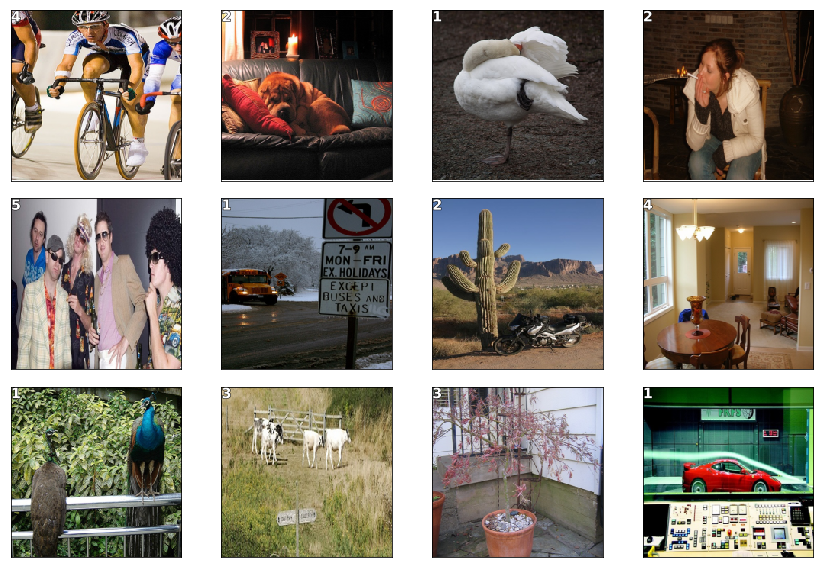

In [94]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    txt = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), txt)
plt.tight_layout()

In [95]:
for fn in md.val_ds.fnames[:12]:
    print(fn[len('VOC2007/JPEGImages/'):] + ' - ' + str(obj_count[fn[len('VOC2007/JPEGImages/'):]]))

000129.jpg - 3
000140.jpg - 2
000189.jpg - 1
000192.jpg - 1
000200.jpg - 7
000207.jpg - 1
000219.jpg - 1
000235.jpg - 3
000294.jpg - 2
000306.jpg - 3
000307.jpg - 2
000317.jpg - 1
